In [2]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [3]:
m = pd.read_csv('dataset/ceb-matrix.csv', index_col='filename').to_numpy()
pg_total = m[:, 0].sum()
optimal_total = np.min(m, axis=1).sum()
print('pg_total:', pg_total)
print('optimal_total:', optimal_total)

pg_p90 = np.percentile(m[:, 0], 90)
optimal_p90 = np.percentile(np.min(m, axis=1), 90)
print('pg_p90:', pg_p90)
print('optimal_p90:', optimal_p90)

pg_total: 10587.665450334549
optimal_total: 3688.4883341789246
pg_p90: 4.558033323287964
optimal_p90: 2.603392314910889


In [4]:
def get_data(filename):
    total_latency = []
    p50 = []
    p90 = []
    p95 = []
    p99 = []
    execution_time = []
    training_time = []
    inference_time = []
    mse = []

    with open(filename) as f:
        results = json.load(f)
        for result in results:
            total_latency.append(result["total_latency"] / 3600)
            p50.append(result["p50"])
            p90.append(result["p90"])
            p95.append(result["p95"])
            p99.append(result["p99"])
            execution_time.append(result["exec_time"] / 3600 - pg_total / 3600)
            training_time.append(result["training_time"])
            inference_time.append(result["inference_time"])
            if "mse" in result:
                mse.append(result["mse"])
    
    training_time_cdf = np.cumsum(training_time)
    inference_time_cdf = np.cumsum(inference_time)
    pg_total_hour = pg_total / 3600
    df = pd.DataFrame({
        "total_latency": total_latency,
        "improvement": (pg_total_hour - total_latency) / pg_total_hour,
        "latency_median": p50,
        "latency_p90": p90,
        "latency_p95": p95,
        "latency_p99": p99,
        "execution_time": execution_time,
        # "execution_time": execution_time + (training_time_cdf + inference_time_cdf) / 3600,
        "training_time": training_time,
        "inference_time": inference_time,
    })
    df['overhead_time'] = df['training_time'] + df['inference_time']
    df['overhead_time_cdf'] = df['overhead_time'].cumsum()
    
    if len(mse) > 0:
        df["mse"] = mse
    
    return df

In [5]:
def combine_plot(p_mc_lists, mc_lists):

    start = -np.inf
    end = np.inf
    for i in range(len(p_mc_lists)):
        p_min = np.min(p_mc_lists[i])
        p_max = np.max(p_mc_lists[i])
        start = max(start, p_min)
        end = min(end, p_max)
    
    
    x_combined = np.linspace(start, end, 5000)
    y_combined = np.zeros_like(x_combined)
    fi_list = []
    for i in range(len(p_mc_lists)):
        fi = interp1d(p_mc_lists[i], mc_lists[i], kind='linear')
        y_combined += fi(x_combined)
        fi_list.append(fi(x_combined))

    y_combined = y_combined / len(p_mc_lists)
    std = np.std(fi_list, axis=0)
    
    return x_combined, y_combined, std

def get_multiple(path, x_name, y_name, n=20):

    x_list, y_list = [], []
    for i in range(1,n+1):
        df = get_data(path.format(i))
        x_list.append(df[x_name])
        y_list.append(df[y_name])
    
    x_combined, y_combined, std = combine_plot(x_list, y_list)
    
    return x_combined, y_combined, std

In [6]:
linewidth=3
markersize=10
gridwidth=1.5
bwith=2
ticks_fontsize=18
label_fontsize=24
title_fontsize=24
fontweight='normal'
markeredgecolor = 'k'
color_scheme = [
    "#4995c6",  # 蓝色
    "#d47628",  # 黄色
    "#8fb943",  # 绿色
    "#d15c6b",  # 红色
    "#8481ba",  # 紫色
    "#413123",  # 棕色
    "#f7a128",  # 橙色,
    "#a5a5a5",  # 灰色,
    "#011F5B",  # 深蓝色
]

line_styles = ['-', '--', '-.', ':', '-', '--']

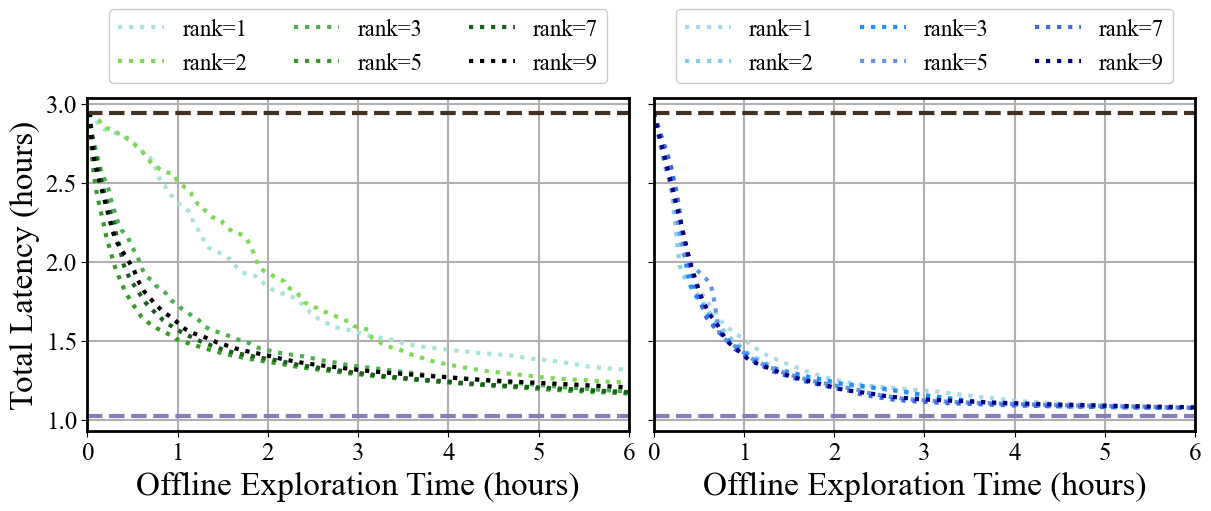

In [112]:
# Draw different rank for limeqo and limeqo+

fig, axs = plt.subplots(1,2, figsize=(12, 5), sharey=True, sharex=True, constrained_layout=True)

plt.rcParams["font.family"] = "Times New Roman"

ax = axs[0]
ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
ax.tick_params(axis='x', labelsize=ticks_fontsize, length=4)
ax.tick_params(axis='y', labelsize=ticks_fontsize, length=4)
# axi.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center')
ax.grid(linewidth=gridwidth)

colors = [
    "#A8E6CE",  # Light Green
    "#7ED957",  # Medium Light Green
    "#4CAF50",  # Medium Green
    "#45B039",  # Moderate Green
    "#3DA52B",  # Slightly Darker Green
    "#359B24",  # Dark Medium Green
    "#2E8E1D",  # Deep Green
    "#278C18",  # Very Dark Green
    "#1F7A13",  # Dark Olive Green
    "#1B5E20",  # Dark Green
    "#000000", # Black
]

x, y, std = get_multiple("experiment/ceb/limeqo/rank1/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = colors[0], label='rank=1', linestyle=line_styles[3],  linewidth=linewidth)

x, y, std = get_multiple("experiment/ceb/limeqo/rank2/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = colors[1], label='rank=2', linestyle=line_styles[3],  linewidth=linewidth)

x, y, std = get_multiple("experiment/ceb/limeqo/rank3/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = colors[2], label='rank=3', linestyle=line_styles[3],  linewidth=linewidth)

# x, y, std = get_multiple("experiment/ceb/limeqo/rank4/{}.json", "execution_time", "total_latency", n=20)
# ax.plot(x, y, color = colors[3], label='rank=4', linestyle=line_styles[3],  linewidth=linewidth)

x, y, std = get_multiple("experiment/ceb/limeqo/rank5/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = colors[5], label='rank=5', linestyle=line_styles[3],  linewidth=linewidth)

# x, y, std = get_multiple("experiment/ceb/limeqo/rank6/{}.json", "execution_time", "total_latency", n=20)
# ax.plot(x, y, color = colors[8], label='rank=6', linestyle=line_styles[3],  linewidth=linewidth)

x, y, std = get_multiple("experiment/ceb/limeqo/rank7/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = colors[9], label='rank=7', linestyle=line_styles[3],  linewidth=linewidth)

x, y, std = get_multiple("experiment/ceb/limeqo/rank9/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = colors[10], label='rank=9', linestyle=line_styles[3],  linewidth=linewidth)

# df = get_data("experiment/ceb/oracle.json")
# ax.plot(df["execution_time"], df["total_latency"], color = color_scheme[4], label='Oracle', linestyle=line_styles[4],  linewidth=linewidth)

ax.axhline(pg_total/3600, color = color_scheme[5], linestyle=line_styles[5], linewidth=linewidth) # PG
ax.axhline(optimal_total/3600, color = color_scheme[4], linestyle=line_styles[5], linewidth=linewidth) # Optimal

ax.legend(framealpha=1,fontsize=16.5, loc='upper center',ncol=3, bbox_to_anchor=(0.5, 1.3))
ax.grid('--')
ax.set_xlim(-0, 6)
# ax.set_ylim(0, 3)
ax.set_xlabel('Offline Exploration Time (hours)', fontsize=label_fontsize, fontweight=fontweight)
ax.set_ylabel('Total Latency (hours)', fontsize=label_fontsize, fontweight=fontweight)

ax = axs[1]
ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
ax.tick_params(axis='x', labelsize=ticks_fontsize, length=4)
ax.tick_params(axis='y', labelsize=ticks_fontsize, length=4)
# axi.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center')
ax.grid(linewidth=gridwidth)

colors = [
    "#ADD8E6",  # Light Blue
    "#87CEEB",  # Sky Blue
    "#00BFFF",  # Deep Sky Blue
    "#1E90FF",  # Dodger Blue
    "#6495ED",  # Cornflower Blue
    "#7B68EE",  # Medium Slate Blue
    "#4169E1",  # Royal Blue
    "#0000CD",  # Medium Blue
    "#00008B",  # Dark Blue
    "#000080"   # Navy Blue
]

x, y, std = get_multiple("experiment/ceb/limeqo+/rank1/{}.json", "execution_time", "total_latency", n=5)
ax.plot(x, y, color = colors[0], label='rank=1', linestyle=line_styles[3],  linewidth=linewidth)

x, y, std = get_multiple("experiment/ceb/limeqo+/rank2/{}.json", "execution_time", "total_latency", n=5)
ax.plot(x, y, color = colors[1], label='rank=2', linestyle=line_styles[3],  linewidth=linewidth)

x, y, std = get_multiple("experiment/ceb/limeqo+/rank3/{}.json", "execution_time", "total_latency", n=5)
ax.plot(x, y, color = colors[3], label='rank=3', linestyle=line_styles[3],  linewidth=linewidth)

# x, y, std = get_multiple("experiment/ceb/limeqo+/beta10rank4/{}.json", "execution_time", "total_latency", n=5)
# ax.plot(x, y, color = color_scheme[5], label='rank=4', linestyle=line_styles[3],  linewidth=linewidth)

x, y, std = get_multiple("experiment/ceb/limeqo+/rank5/{}.json", "execution_time", "total_latency", n=5)
ax.plot(x, y, color = colors[4], label='rank=5', linestyle=line_styles[3],  linewidth=linewidth)

# x, y, std = get_multiple("experiment/ceb/limeqo+/beta10rank6/{}.json", "execution_time", "total_latency", n=5)
# ax.plot(x, y, color = color_scheme[6], label='rank=6', linestyle=line_styles[3],  linewidth=linewidth)

x, y, std = get_multiple("experiment/ceb/limeqo+/rank7/{}.json", "execution_time", "total_latency", n=5)
ax.plot(x, y, color = colors[6], label='rank=7', linestyle=line_styles[3],  linewidth=linewidth)

x, y, std = get_multiple("experiment/ceb/limeqo+/rank9/{}.json", "execution_time", "total_latency", n=5)
ax.plot(x, y, color = colors[9], label='rank=9', linestyle=line_styles[3],  linewidth=linewidth)


# df = get_data("experiment/ceb/oracle.json")
# ax.plot(df["execution_time"], df["total_latency"], color = color_scheme[4], label='Oracle', linestyle=line_styles[4],  linewidth=linewidth)

ax.axhline(pg_total/3600, color = color_scheme[5], linestyle=line_styles[5], linewidth=linewidth) # PG
ax.axhline(optimal_total/3600, color = color_scheme[4], linestyle=line_styles[5], linewidth=linewidth) # Optimal

ax.legend(framealpha=1,fontsize=16.5, loc='upper center',ncol=3, bbox_to_anchor=(0.5, 1.3))
ax.grid('--')

ax.set_xlabel('Offline Exploration Time (hours)', fontsize=label_fontsize, fontweight=fontweight)

fig.savefig('fig/rank.pdf', bbox_inches='tight')

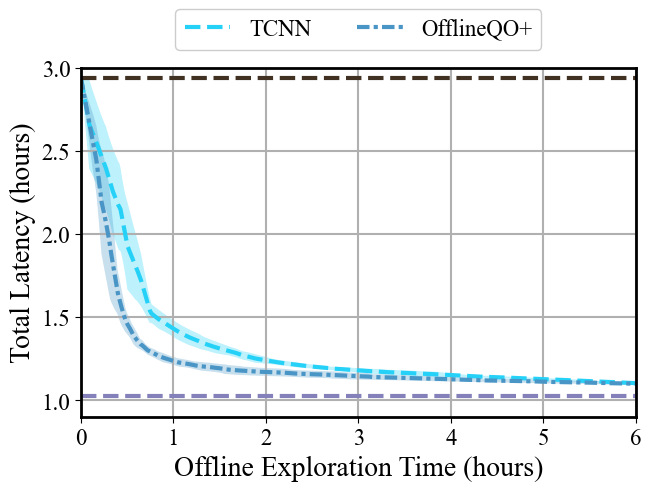

In [9]:

fig, ax = plt.subplots(1,1, constrained_layout=True)

# set font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"
ticks_fontsize = 16.5
label_fontsize = 20

# ax = axs[0]
ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
ax.tick_params(axis='x', labelsize=ticks_fontsize, length=4)
ax.tick_params(axis='y', labelsize=ticks_fontsize, length=4)
# axi.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center')
ax.grid(linewidth=gridwidth)

color_scheme[3] = "#25d1f7"

x, y, std = get_multiple("experiment/ceb/tcnn/{}.json", "execution_time", "total_latency", n=5)
ax.plot(x, y, color = color_scheme[3], label='TCNN', linestyle=line_styles[1],  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[3], linewidth=0)

x, y, std = get_multiple("experiment/ceb/limeqo+/{}.json", "execution_time", "total_latency", n=5)
ax.plot(x, y, color = color_scheme[0], label='OfflineQO+', linestyle=(0, (3, 1, 1, 1)),  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[0], linewidth=0)

ax.axhline(pg_total/3600, color = color_scheme[5], linestyle=line_styles[1], linewidth=linewidth) # PG
ax.axhline(optimal_total/3600, color = color_scheme[4], linestyle=line_styles[1], linewidth=linewidth) # Optimal

ax.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center',ncol=3, bbox_to_anchor=(0.5, 1.2))
ax.grid('--')
ax.set_xlim(-0, 6)
ax.set_ylim(0.9, 3)
ax.set_ylabel('Total Latency (hours)', fontsize=label_fontsize, fontweight=fontweight)
ax.set_xlabel('Offline Exploration Time (hours)', fontsize=label_fontsize, fontweight=fontweight)

# ax = axs[1]

# ax.spines['bottom'].set_linewidth(bwith)
# ax.spines['left'].set_linewidth(bwith)
# ax.spines['top'].set_linewidth(bwith)
# ax.spines['right'].set_linewidth(bwith)
# ax.tick_params(axis='x', labelsize=ticks_fontsize, length=4)
# ax.tick_params(axis='y', labelsize=ticks_fontsize, length=4)
# # axi.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center')
# ax.grid(linewidth=gridwidth)

# x, y, std = get_multiple("experiment/ceb/tcnn/{}.json", "execution_time", "overhead_time_cdf", n=5)
# ax.plot(x, y, color = color_scheme[3], linestyle=line_styles[1],  linewidth=linewidth)
# ax.fill_between(x, y - std, 
#                 y + std, alpha=0.3, color = color_scheme[3], linewidth=0)

# x, y, std = get_multiple("experiment/ceb/limeqo+/{}.json", "execution_time", "overhead_time_cdf", n=5)
# ax.plot(x, y, color = color_scheme[0], linestyle=(0, (3, 1, 1, 1)),  linewidth=linewidth)
# ax.fill_between(x, y - std, 
#                 y + std, alpha=0.3, color = color_scheme[0], linewidth=0)

# fig.legend(framealpha=1,fontsize=label_fontsize, loc='upper center',ncol=2, bbox_to_anchor=(0.5, 1.15))
# ax.grid('--')
# # ax.set_yscale('log')
# ax.set_xlim(-0, 6)
# ax.set_ylim(0, 4200)
# ax.set_yticks([ 0, 600, 1200, 1800, 2400, 3000, 3600, 4200],[ 0, 10, 20, 30, 40, 50, 60, 70])
# ax.set_ylabel('Overhead Time (min)', fontsize=label_fontsize, fontweight=fontweight)
# ax.set_xlabel('Offline Exploration Time (hours)', fontsize=label_fontsize, fontweight=fontweight)


plt.savefig('fig/tcnn.pdf', bbox_inches='tight')

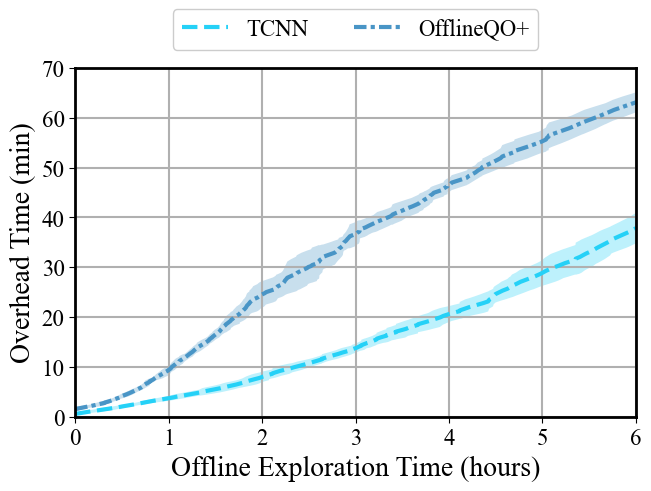

In [13]:

fig, ax = plt.subplots(1,1, constrained_layout=True)

# set font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"
ticks_fontsize = 16.5
label_fontsize = 20


ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
ax.tick_params(axis='x', labelsize=ticks_fontsize, length=4)
ax.tick_params(axis='y', labelsize=ticks_fontsize, length=4)
# axi.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center')
ax.grid(linewidth=gridwidth)

x, y, std = get_multiple("experiment/ceb/tcnn/{}.json", "execution_time", "overhead_time_cdf", n=5)
ax.plot(x, y, color = color_scheme[3], label='TCNN', linestyle=line_styles[1],  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[3], linewidth=0)

x, y, std = get_multiple("experiment/ceb/limeqo+/{}.json", "execution_time", "overhead_time_cdf", n=5)
ax.plot(x, y, color = color_scheme[0], label='OfflineQO+', linestyle=(0, (3, 1, 1, 1)),  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[0], linewidth=0)

# fig.legend(framealpha=1,fontsize=label_fontsize, loc='upper center',ncol=2, bbox_to_anchor=(0.5, 1.15))
ax.grid('--')
# ax.set_yscale('log')
ax.set_xlim(-0, 6)
ax.set_ylim(0, 4200)
ax.set_yticks([ 0, 600, 1200, 1800, 2400, 3000, 3600, 4200],[ 0, 10, 20, 30, 40, 50, 60, 70])
ax.set_ylabel('Overhead Time (min)', fontsize=label_fontsize, fontweight=fontweight)
ax.set_xlabel('Offline Exploration Time (hours)', fontsize=label_fontsize, fontweight=fontweight)
ax.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center',ncol=3, bbox_to_anchor=(0.5, 1.2))


plt.savefig('fig/tcnn_overhead.pdf', bbox_inches='tight')

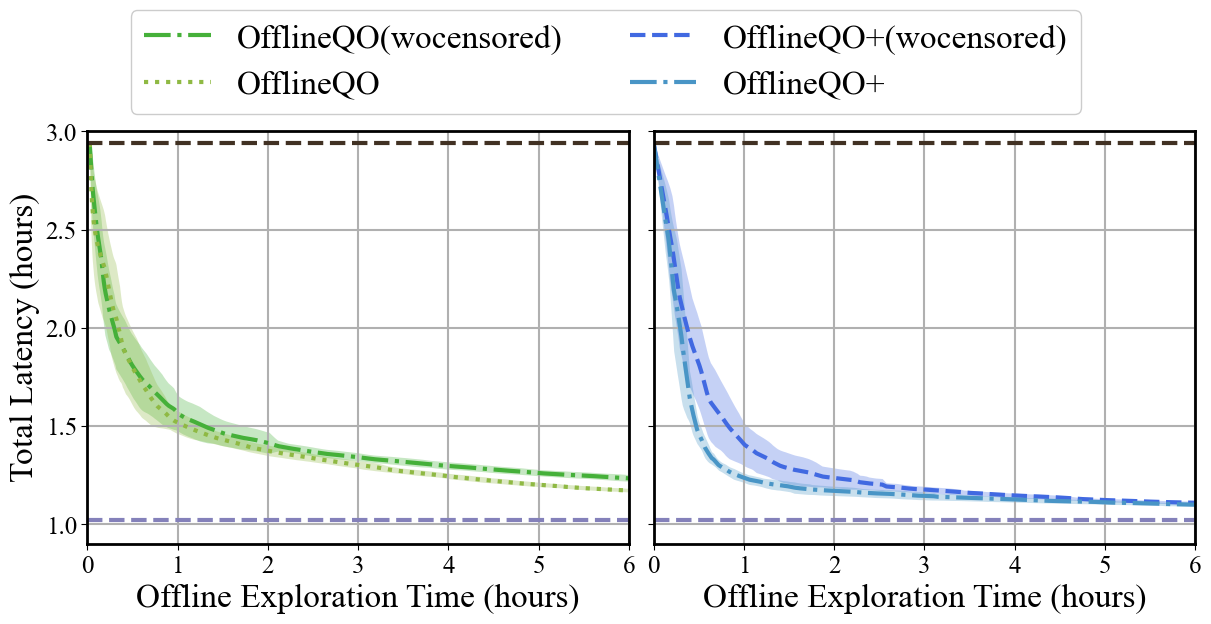

In [113]:

fig, axs = plt.subplots(1,2, figsize=(12, 5), sharey=True, sharex=True, constrained_layout=True)

# set font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

ax = axs[0]
ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
ax.tick_params(axis='x', labelsize=ticks_fontsize, length=4)
ax.tick_params(axis='y', labelsize=ticks_fontsize, length=4)
# axi.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center')
ax.grid(linewidth=gridwidth)

color_scheme[3] = "#45B039"

x, y, std = get_multiple("experiment/ceb/limeqo/wocensored_{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = color_scheme[3], label='OfflineQO(wocensored)', linestyle=line_styles[2],  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[3], linewidth=0)

x, y, std = get_multiple("experiment/ceb/limeqo/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = color_scheme[2], label='OfflineQO', linestyle=line_styles[3],  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[2], linewidth=0)

ax.axhline(pg_total/3600, color = color_scheme[5], linestyle=line_styles[1], linewidth=linewidth) # PG
ax.axhline(optimal_total/3600, color = color_scheme[4], linestyle=line_styles[1], linewidth=linewidth) # Optimal

# ax.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center',ncol=3, bbox_to_anchor=(0.5, 1.3))
ax.grid('--')
ax.set_xlim(-0, 6)
ax.set_ylim(0.9, 3)
ax.set_ylabel('Total Latency (hours)', fontsize=label_fontsize, fontweight=fontweight)
ax.set_xlabel('Offline Exploration Time (hours)', fontsize=label_fontsize, fontweight=fontweight)

ax = axs[1]

ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
ax.tick_params(axis='x', labelsize=ticks_fontsize, length=4)
ax.tick_params(axis='y', labelsize=ticks_fontsize, length=4)
# axi.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center')
ax.grid(linewidth=gridwidth)

color_scheme[1] = "#4169E1"

x, y, std = get_multiple("experiment/ceb/limeqo+/beta10_wocensored_{}.json", "execution_time", "total_latency", n=5)
ax.plot(x, y, color = color_scheme[1], label='OfflineQO+(wocensored)', linestyle=line_styles[1],  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[1], linewidth=0)

x, y, std = get_multiple("experiment/ceb/limeqo+/{}.json", "execution_time", "total_latency", n=5)
ax.plot(x, y, color = color_scheme[0], label='OfflineQO+', linestyle=line_styles[2],  linewidth=linewidth)
ax.fill_between(x, y - std, 
                y + std, alpha=0.3, color = color_scheme[0], linewidth=0)

ax.axhline(pg_total/3600, color = color_scheme[5], linestyle=line_styles[1], linewidth=linewidth) # PG
ax.axhline(optimal_total/3600, color = color_scheme[4], linestyle=line_styles[1], linewidth=linewidth) # Optimal

fig.legend(framealpha=1,fontsize=24, loc='upper center',ncol=2, bbox_to_anchor=(0.5, 1.25))
ax.grid('--')
# ax.set_yscale('log')
ax.set_xlabel('Offline Exploration Time (hours)', fontsize=label_fontsize, fontweight=fontweight)


plt.savefig('fig/censor.pdf', bbox_inches='tight')

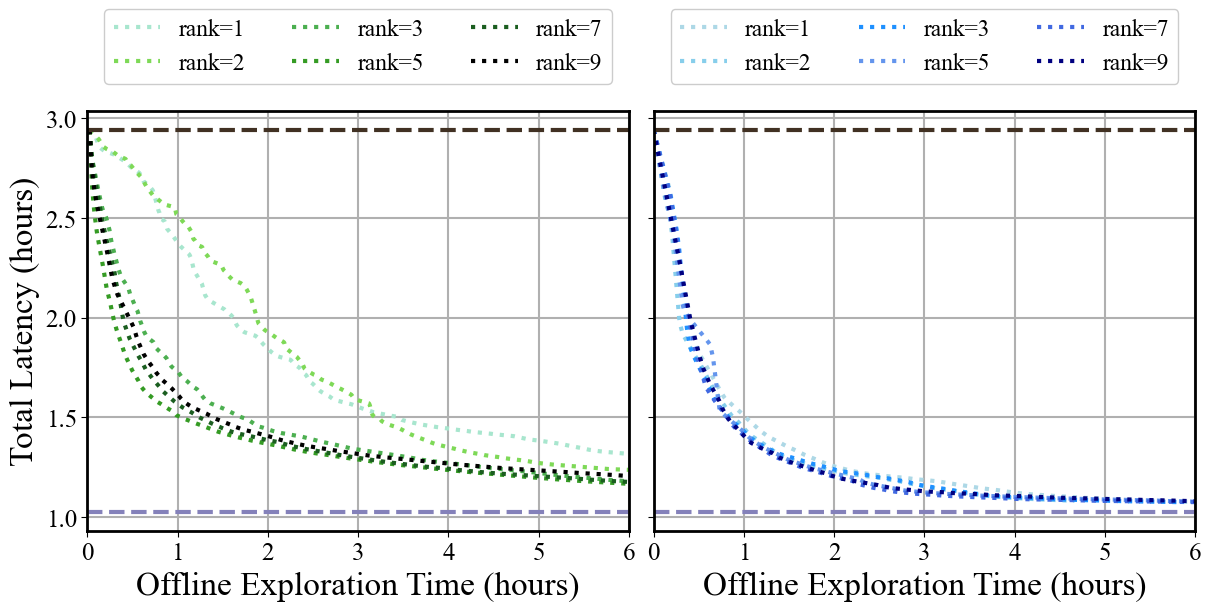

In [126]:
# Draw different rank for limeqo and limeqo+

fig, axs = plt.subplots(1,2, figsize=(12, 6), sharey=True, sharex=True, constrained_layout=True)

plt.rcParams["font.family"] = "Times New Roman"

ax = axs[0]
ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
ax.tick_params(axis='x', labelsize=ticks_fontsize, length=4)
ax.tick_params(axis='y', labelsize=ticks_fontsize, length=4)
# axi.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center')
ax.grid(linewidth=gridwidth)

colors = [
    "#A8E6CE",  # Light Green
    "#7ED957",  # Medium Light Green
    "#4CAF50",  # Medium Green
    "#45B039",  # Moderate Green
    "#3DA52B",  # Slightly Darker Green
    "#359B24",  # Dark Medium Green
    "#2E8E1D",  # Deep Green
    "#278C18",  # Very Dark Green
    "#1F7A13",  # Dark Olive Green
    "#1B5E20",  # Dark Green
    "#000000", # Black
]

x, y, std = get_multiple("experiment/ceb/limeqo/rank1/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = colors[0], label='rank=1', linestyle=line_styles[3],  linewidth=linewidth)

x, y, std = get_multiple("experiment/ceb/limeqo/rank2/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = colors[1], label='rank=2', linestyle=line_styles[3],  linewidth=linewidth)

x, y, std = get_multiple("experiment/ceb/limeqo/rank3/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = colors[2], label='rank=3', linestyle=line_styles[3],  linewidth=linewidth)

# x, y, std = get_multiple("experiment/ceb/limeqo/rank4/{}.json", "execution_time", "total_latency", n=20)
# ax.plot(x, y, color = colors[3], label='rank=4', linestyle=line_styles[3],  linewidth=linewidth)

x, y, std = get_multiple("experiment/ceb/limeqo/rank5/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = colors[5], label='rank=5', linestyle=line_styles[3],  linewidth=linewidth)

# x, y, std = get_multiple("experiment/ceb/limeqo/rank6/{}.json", "execution_time", "total_latency", n=20)
# ax.plot(x, y, color = colors[8], label='rank=6', linestyle=line_styles[3],  linewidth=linewidth)

x, y, std = get_multiple("experiment/ceb/limeqo/rank7/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = colors[9], label='rank=7', linestyle=line_styles[3],  linewidth=linewidth)

x, y, std = get_multiple("experiment/ceb/limeqo/rank9/{}.json", "execution_time", "total_latency", n=20)
ax.plot(x, y, color = colors[10], label='rank=9', linestyle=line_styles[3],  linewidth=linewidth)

# df = get_data("experiment/ceb/oracle.json")
# ax.plot(df["execution_time"], df["total_latency"], color = color_scheme[4], label='Oracle', linestyle=line_styles[4],  linewidth=linewidth)

ax.axhline(pg_total/3600, color = color_scheme[5], linestyle=line_styles[5], linewidth=linewidth) # PG
ax.axhline(optimal_total/3600, color = color_scheme[4], linestyle=line_styles[5], linewidth=linewidth) # Optimal

ax.legend(framealpha=1,fontsize=16.8, loc='upper center',ncol=3, bbox_to_anchor=(0.5, 1.27))
ax.grid('--')
ax.set_xlim(-0, 6)
# ax.set_ylim(0, 3)
ax.set_xlabel('Offline Exploration Time (hours)', fontsize=label_fontsize, fontweight=fontweight)
ax.set_ylabel('Total Latency (hours)', fontsize=label_fontsize, fontweight=fontweight)

ax = axs[1]
ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
ax.spines['top'].set_linewidth(bwith)
ax.spines['right'].set_linewidth(bwith)
ax.tick_params(axis='x', labelsize=ticks_fontsize, length=4)
ax.tick_params(axis='y', labelsize=ticks_fontsize, length=4)
# axi.legend(framealpha=1,fontsize=ticks_fontsize, loc='upper center')
ax.grid(linewidth=gridwidth)

colors = [
    "#ADD8E6",  # Light Blue
    "#87CEEB",  # Sky Blue
    "#00BFFF",  # Deep Sky Blue
    "#1E90FF",  # Dodger Blue
    "#6495ED",  # Cornflower Blue
    "#7B68EE",  # Medium Slate Blue
    "#4169E1",  # Royal Blue
    "#0000CD",  # Medium Blue
    "#00008B",  # Dark Blue
    "#000080"   # Navy Blue
]

x, y, std = get_multiple("experiment/ceb/limeqo+/rank1/{}.json", "execution_time", "total_latency", n=5)
ax.plot(x, y, color = colors[0], label='rank=1', linestyle=line_styles[3],  linewidth=linewidth)

x, y, std = get_multiple("experiment/ceb/limeqo+/rank2/{}.json", "execution_time", "total_latency", n=5)
ax.plot(x, y, color = colors[1], label='rank=2', linestyle=line_styles[3],  linewidth=linewidth)

x, y, std = get_multiple("experiment/ceb/limeqo+/rank3/{}.json", "execution_time", "total_latency", n=5)
ax.plot(x, y, color = colors[3], label='rank=3', linestyle=line_styles[3],  linewidth=linewidth)

# x, y, std = get_multiple("experiment/ceb/limeqo+/beta10rank4/{}.json", "execution_time", "total_latency", n=5)
# ax.plot(x, y, color = color_scheme[5], label='rank=4', linestyle=line_styles[3],  linewidth=linewidth)

x, y, std = get_multiple("experiment/ceb/limeqo+/rank5/{}.json", "execution_time", "total_latency", n=5)
ax.plot(x, y, color = colors[4], label='rank=5', linestyle=line_styles[3],  linewidth=linewidth)

# x, y, std = get_multiple("experiment/ceb/limeqo+/beta10rank6/{}.json", "execution_time", "total_latency", n=5)
# ax.plot(x, y, color = color_scheme[6], label='rank=6', linestyle=line_styles[3],  linewidth=linewidth)

x, y, std = get_multiple("experiment/ceb/limeqo+/rank7/{}.json", "execution_time", "total_latency", n=5)
ax.plot(x, y, color = colors[6], label='rank=7', linestyle=line_styles[3],  linewidth=linewidth)

x, y, std = get_multiple("experiment/ceb/limeqo+/rank9/{}.json", "execution_time", "total_latency", n=5)
ax.plot(x, y, color = colors[9], label='rank=9', linestyle=line_styles[3],  linewidth=linewidth)


# df = get_data("experiment/ceb/oracle.json")
# ax.plot(df["execution_time"], df["total_latency"], color = color_scheme[4], label='Oracle', linestyle=line_styles[4],  linewidth=linewidth)

ax.axhline(pg_total/3600, color = color_scheme[5], linestyle=line_styles[5], linewidth=linewidth) # PG
ax.axhline(optimal_total/3600, color = color_scheme[4], linestyle=line_styles[5], linewidth=linewidth) # Optimal

ax.legend(framealpha=1,fontsize=16.8, loc='upper center',ncol=3, bbox_to_anchor=(0.5, 1.27))
ax.grid('--')

ax.set_xlabel('Offline Exploration Time (hours)', fontsize=label_fontsize, fontweight=fontweight)

fig.savefig('fig/rank.pdf', bbox_inches='tight')